# Homework 1

This notebook collects monthly pageview data for a set of rare disease-related articles from English Wikipedia, from July 1, 2015, to September 30, 2024, using the Wikimedia Analytics API. The collected data is saved in JSON format and analyzed to generate visualizations of article traffic over time. The analysis includes plotting the highest and lowest average pageviews, the top 10 articles by peak pageviews, and the articles with the fewest months of available data. This project follows best practices for reproducibility and includes detailed documentation of each step in the data acquisition, processing, and analysis stages

This code Assignment was developed by Sparsh Nagpal for use in DATA 512, a course in the UW MS Data Science degree program. [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024

## Step 1: Data Acquisition

In [148]:
import json
from urllib.parse import quote
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests

In [145]:
# Constants for API call and articles
API_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
API_LATENCY_ASSUMED = 0.002
API_THROTTLE_WAIT = (1.0 / 100.0) - API_LATENCY_ASSUMED
REQUEST_HEADERS = {
    'User-Agent': 'sparshna@washington.edu, Professionalism and Reproducibility - Homework 1'
}

# Date range: from July 1, 2015 to September 30, 2024
START_DATE = '20150701'
END_DATE = '20240930'

# Wikipedia project for English articles
PROJECT = 'en.wikipedia'

In [146]:
# Function to fetch data from Wikimedia Pageviews API
def fetch_pageviews(article, access, start, end):
    ''' 
    Fetches pageviews data for a given article and access type from the Wikimedia Pageviews API.
    '''
    url = API_ENDPOINT.format(
        project=PROJECT,
        access=access,
        agent='user',  # We're interested in actual user requests
        article= quote(article.replace(' ','_')),  # Article title in URL-encoded format
        granularity='monthly',
        start=start,
        end=end
    )
    
    response = requests.get(url, headers=REQUEST_HEADERS)
    if response.status_code == 200:
        time.sleep(API_THROTTLE_WAIT)
        return response.json()
    else:
        print(f"Failed to retrieve data for {article} ({access}). Status code: {response.status_code}")
        return None

In [ ]:
# article list (Disease names)
df = pd.read_csv("rare-disease_cleaned.AUG.2024.csv")

# Extract the first column values
articles = df.iloc[:, 0].tolist()

# Collecting data for all articles and saving to JSON files
mobile_data = {}
desktop_data = {}
cumulative_data = {}

for article in tqdm(articles):
    # Fetch mobile data (summing mobile-app and mobile-web)
    mobile_app_data = fetch_pageviews(article, 'mobile-app', START_DATE, END_DATE)
    mobile_web_data = fetch_pageviews(article, 'mobile-web', START_DATE, END_DATE)
    
    if mobile_app_data and mobile_web_data:
        # Summing both mobile access types
        combined_mobile_data = mobile_app_data.copy()
        for i, record in enumerate(combined_mobile_data['items']):
            record['views'] += mobile_web_data['items'][i]['views']
        mobile_data[article] = combined_mobile_data

    # Fetch desktop data
    desktop_result = fetch_pageviews(article, 'desktop', START_DATE, END_DATE)
    if desktop_result:
        desktop_data[article] = desktop_result

    # Summing to create cumulative data (mobile + desktop)
    if article in mobile_data and article in desktop_data:
        cumulative = mobile_data[article].copy()
        for i, record in enumerate(cumulative['items']):
            record['views'] += desktop_data[article]['items'][i]['views']
        cumulative_data[article] = cumulative

In [ ]:
# Ensure the 'data' directory exists
os.makedirs('data', exist_ok=True)

# Save the data to JSON files
with open('data/rare-disease_monthly_mobile_201507-202409.json', 'w') as f:
    json.dump(mobile_data, f)

with open('data/rare-disease_monthly_desktop_201507-202409.json', 'w') as f:
    json.dump(desktop_data, f)

with open('data/rare-disease_monthly_cumulative_201507-202409.json', 'w') as f:
    json.dump(cumulative_data, f)

## Step 2: Analysis

In [189]:
# Load the saved JSON data
with open('data/rare-disease_monthly_mobile_201507-202409.json', 'r') as f:
    mobile_data = json.load(f)

with open('data/rare-disease_monthly_desktop_201507-202409.json', 'r') as f:
    desktop_data = json.load(f)

In [190]:
# Convert JSON to DataFrame
def json_to_df(data):
    records = []
    for article, article_data in data.items():
        for item in article_data['items']:
            records.append({
                'article': article,
                'timestamp': item['timestamp'],
                'views': item['views']
            })
    return pd.DataFrame(records)

df_mobile = json_to_df(mobile_data)
df_desktop = json_to_df(desktop_data)

In [191]:
# Convert timestamp to datetime (remove last two characters '00')
df_mobile['timestamp'] = pd.to_datetime(df_mobile['timestamp'].str[:-2], format='%Y%m%d')
df_desktop['timestamp'] = pd.to_datetime(df_desktop['timestamp'].str[:-2], format='%Y%m%d')

# Group by article and calculate average views
avg_mobile = df_mobile.groupby('article')['views'].mean().reset_index().rename(columns={'views': 'avg_mobile'})
avg_desktop = df_desktop.groupby('article')['views'].mean().reset_index().rename(columns={'views': 'avg_desktop'})

### Maximum Average and Minimum Average

In [193]:
#max of avg_mobile and the article belonging to it
max_mobile = avg_mobile.loc[avg_mobile['avg_mobile'].idxmax()]

#min of avg_mobile and the article belonging to it
min_mobile = avg_mobile.loc[avg_mobile['avg_mobile'].idxmin()]

#max of avg_desktop and the article belonging to it
max_desktop = avg_desktop.loc[avg_desktop['avg_desktop'].idxmax()]

#min of avg_desktop and the article belonging to it
min_desktop = avg_desktop.loc[avg_desktop['avg_desktop'].idxmin()]

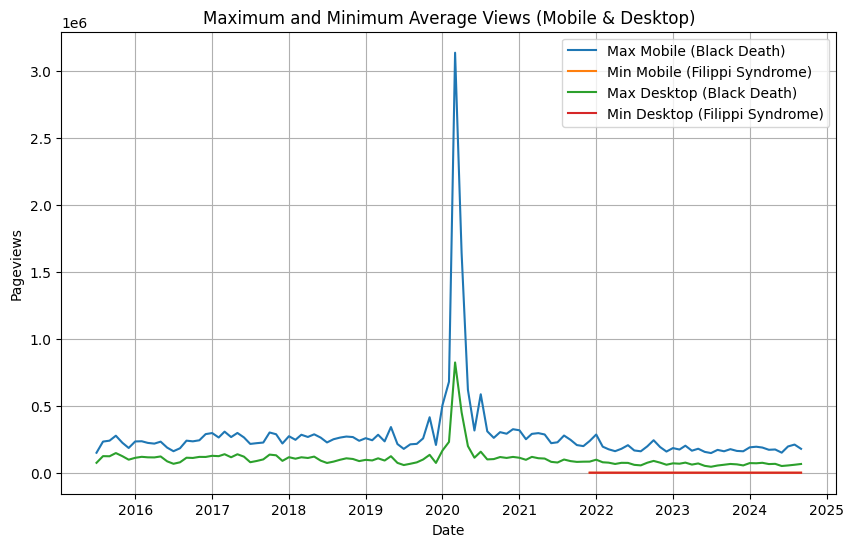

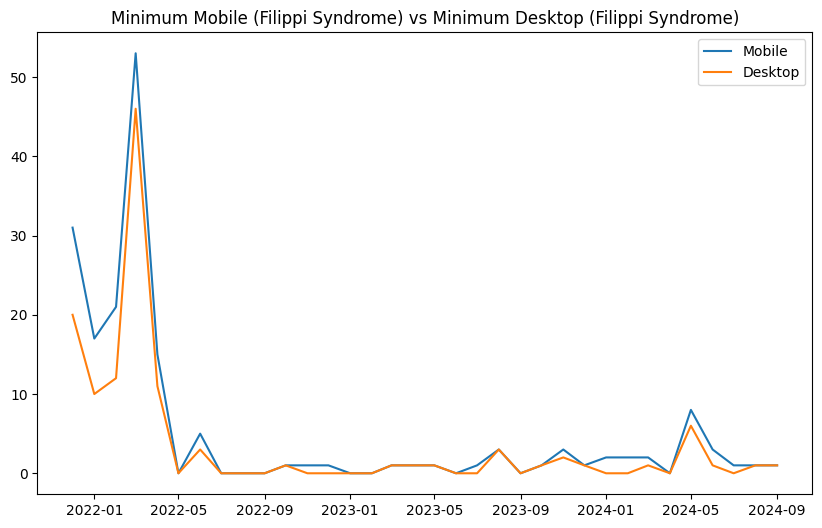

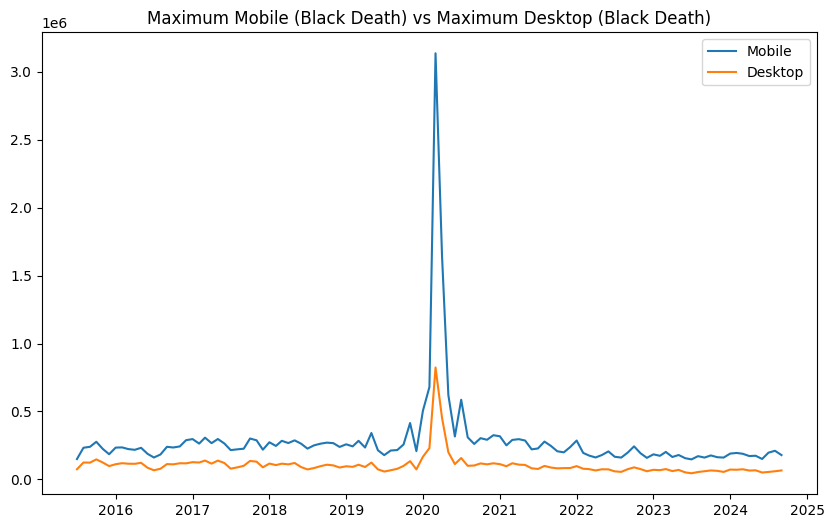

In [194]:
# Plotting the max and min data
fig, ax = plt.subplots(figsize=(10, 6))

for article, label in [(max_mobile['article'], 'Max Mobile'), (min_mobile['article'], 'Min Mobile'),
                       (max_desktop['article'], 'Max Desktop'), (min_desktop['article'], 'Min Desktop')]:
    if label.endswith('Mobile'):
        df = df_mobile[df_mobile['article'] == article]
    else:
        df = df_desktop[df_desktop['article'] == article]
    ax.plot(df['timestamp'], df['views'], label=f"{label} ({article})")

ax.set_title('Maximum and Minimum Average Views (Mobile & Desktop)')
ax.set_xlabel('Date')
ax.set_ylabel('Pageviews')
ax.legend()
plt.grid(True)
plt.savefig('data/max_min_avg_views.png')
plt.show()


df_mobile_min = df_mobile[df_mobile['article'] == min_mobile['article']]
df_desktop_min = df_desktop[df_mobile['article'] == min_desktop['article']]

# Plot the average views of df_desktop_min and df_mobile_max over years
plt.figure(figsize=(10, 6))
plt.plot(df_mobile_min['timestamp'], df_mobile_min['views'], label='Mobile')
plt.plot(df_desktop_min['timestamp'], df_desktop_min['views'], label='Desktop')
plt.title(f'Minimum Mobile ({min_mobile["article"]}) vs Minimum Desktop ({min_desktop["article"]})')
plt.legend()
plt.show()

# max_mobile for avg_mobile, min_mobile for avg_mobile, max_desktop for avg_desktop, min_desktop for avg_desktop over time visualization
df_mobile_max = df_mobile[df_mobile['article'] == max_mobile['article']]
df_desktop_max = df_desktop[df_mobile['article'] == max_desktop['article']]

# Plot the average views of df_desktop_min and df_mobile_max over years
plt.figure(figsize=(10, 6))
plt.plot(df_mobile_max['timestamp'], df_mobile_max['views'], label='Mobile')
plt.plot(df_desktop_max['timestamp'], df_desktop_max['views'], label='Desktop')
plt.title(f'Maximum Mobile ({max_mobile["article"]}) vs Maximum Desktop ({max_desktop["article"]})')
plt.legend()
plt.show()

### Top 10 Peak Page Views

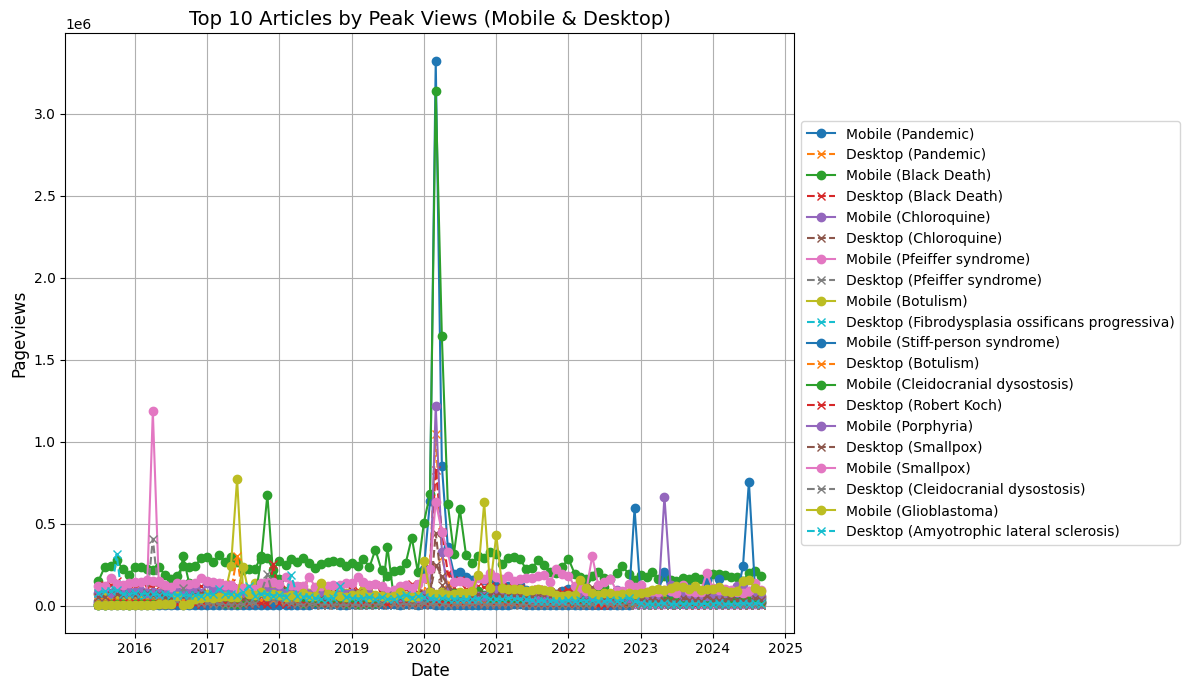

In [198]:
# Find the peak month for each article
peak_mobile = df_mobile.groupby('article')['views'].idxmax()
peak_desktop = df_desktop.groupby('article')['views'].idxmax()

# Get the top 10 articles by peak views
top_mobile = df_mobile.loc[peak_mobile].sort_values('views', ascending=False).head(10)
top_desktop = df_desktop.loc[peak_desktop].sort_values('views', ascending=False).head(10)

# Plot the top 10 articles by peak views
fig, ax = plt.subplots(figsize=(12, 7))

for article, label in zip(top_mobile['article'], top_desktop['article']):
    df_mobile_plot = df_mobile[df_mobile['article'] == article]
    ax.plot(df_mobile_plot['timestamp'], df_mobile_plot['views'], label=f"Mobile ({article})", linestyle='-', marker='o')

    df_desktop_plot = df_desktop[df_desktop['article'] == label]
    ax.plot(df_desktop_plot['timestamp'], df_desktop_plot['views'], label=f"Desktop ({label})", linestyle='--', marker='x')

# Adjust the title, labels, and grid
ax.set_title('Top 10 Articles by Peak Views (Mobile & Desktop)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Pageviews', fontsize=12)
ax.grid(True)

# Move the legend outside the plot to avoid overlap
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Save the plot and show
plt.tight_layout()
plt.savefig('data/top_10_peak_views.png')
plt.show()

### Fewest Months of Data

In [199]:
# Get the range of dates for each article
df_desktop['timestamp'] = pd.to_datetime(df_desktop['timestamp'].dt.strftime('%Y-%m'))
article_range_desktop = df_desktop.groupby('article')['timestamp'].agg(['min', 'max'])

# Calculate the total months for each article
article_range_desktop['total_months'] = (article_range_desktop['max'] - article_range_desktop['min']).dt.days // 30

# Sort the articles by total months
article_range_desktop = article_range_desktop.sort_values('total_months', ascending=False)

# Display the least 10 articles by total months
article_range_desktop[-10:]

,min,max,total_months
article,,,
Ellis–Van Creveld syndrome,2021-02-01,2024-09-01,43
Bradley Monk,2021-05-01,2024-09-01,40
Hemolytic jaundice,2021-05-01,2024-09-01,40
Spongy degeneration of the central nervous system,2021-05-01,2024-09-01,40
Deaf plus,2021-05-01,2024-09-01,40
CDKL5 deficiency disorder,2021-06-01,2024-09-01,39
Joseph Vinetz,2021-06-01,2024-09-01,39
COVID-19 vaccine misinformation and hesitancy,2021-09-01,2024-09-01,36
Filippi Syndrome,2021-12-01,2024-09-01,33


In [200]:
df_mobile['timestamp'] = pd.to_datetime(df_mobile['timestamp'].dt.strftime('%Y-%m'))
article_range_mobile = df_mobile.groupby('article')['timestamp'].agg(['min', 'max'])

# Calculate the total months for each article
article_range_mobile['total_months'] = (article_range_mobile['max'] - article_range_mobile['min']).dt.days // 30

# Sort the articles by total months
article_range_mobile = article_range_mobile.sort_values('total_months', ascending=False)

# Display the least 10 articles by total months
article_range_mobile[-10:]

,min,max,total_months
article,,,
Ellis–Van Creveld syndrome,2021-02-01,2024-09-01,43
Bradley Monk,2021-05-01,2024-09-01,40
Hemolytic jaundice,2021-05-01,2024-09-01,40
Spongy degeneration of the central nervous system,2021-05-01,2024-09-01,40
Deaf plus,2021-05-01,2024-09-01,40
CDKL5 deficiency disorder,2021-06-01,2024-09-01,39
Joseph Vinetz,2021-06-01,2024-09-01,39
COVID-19 vaccine misinformation and hesitancy,2021-09-01,2024-09-01,36
Filippi Syndrome,2021-12-01,2024-09-01,33


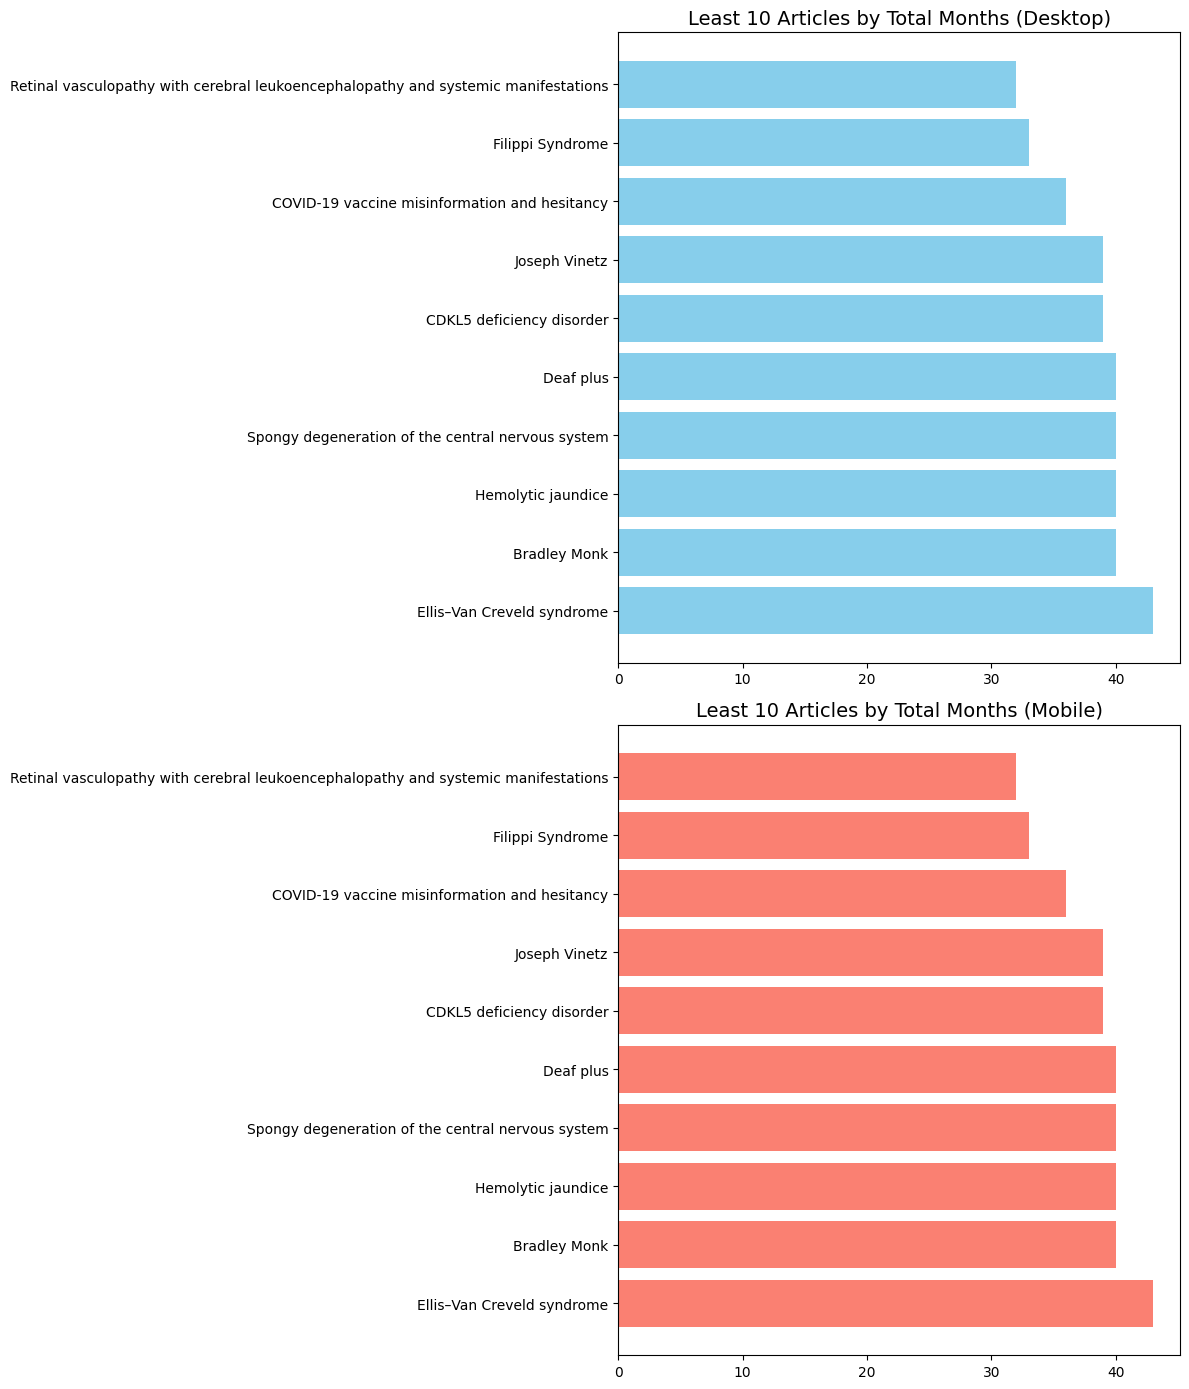

In [201]:
# Visualizae the above two cells
fig, ax = plt.subplots(2, 1, figsize=(12, 14))

# Plot the total months for desktop
ax[0].barh(article_range_desktop.index[-10:], article_range_desktop['total_months'][-10:], color='skyblue')
ax[0].set_title('Least 10 Articles by Total Months (Desktop)', fontsize=14)

# Plot the total months for mobile
ax[1].barh(article_range_mobile.index[-10:], article_range_mobile['total_months'][-10:], color='salmon')
ax[1].set_title('Least 10 Articles by Total Months (Mobile)', fontsize=14)

plt.tight_layout()
plt.savefig('data/least_10_total_months.png')
plt.show()
